# Comparing RNN models on financial data


In [2]:
### Pour utiliser sur google colab

import os

from google.colab import drive

drive.mount('drive')

!mkdir -p drive -v
#!google-drive-ocamlfuse drive

cwd = os.getcwd()


Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [3]:

#### Changez le chemin ci-dessous vers votre repertoire dans votre googledrive
##############################################################################

monchemin = '/content/drive/MyDrive/ECM/DL/financialdata/data/'

dir_path  = os.path.join(cwd, monchemin)
dirs = os.listdir(dir_path)
os.chdir(dir_path)

###  

In [4]:

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

### Getting the data

In [5]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [6]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [7]:
# First, we get the data
dataset = pd.read_csv('IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head(10)

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM
2006-01-10,83.15,84.12,83.12,84.07,5701000,IBM
2006-01-11,84.37,84.81,83.40,84.17,5776500,IBM
2006-01-12,83.82,83.96,83.40,83.57,4926500,IBM
2006-01-13,83.00,83.45,82.50,83.17,6921700,IBM


In [8]:
# Checking for missing values
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

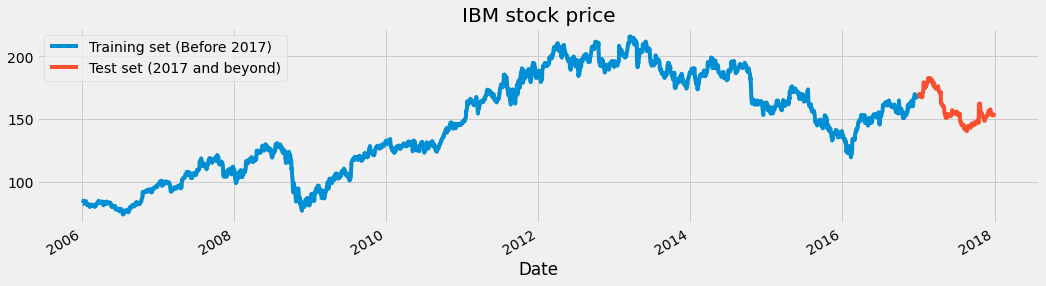

In [9]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [10]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [11]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(2709, 60)

In [12]:
# Reshaping X_train for efficient modelling
X_train = np.expand_dims(X_train, axis=2)

In [13]:
print (X_train.shape)

(2709, 60, 1)


# Experimental comparison

1. Perform learning and plot the predictions of a few learned models   

2. Extensive comparison

Compare SimpleRNN, GRU NNs, LSTM NNs in terms of performance (mse) vs number of parameters for a variery of models while tryoing to get the best performance for a given budget measured as the number of parameters.

Can you find a clear ranking of the three families of models ? 

3. Can these models be trained to perform prediction at a longer range ? For instance predicting the values of one full week ahead (the next 7 days) instead of predicting the value for the next only ?  
- Implement and test a strategy for testting one step ahead prediction for longer range prediction.
- Design implement and test a model for  learning such a long term prediction task.
     
     

#### fonctions de plot de loss

In [14]:
import matplotlib.pyplot as plt

#  fonction de plot de courbes de loss 
def plot_loss(fit_history,title):
  plt.plot(fit_history.history['loss'])
  plt.title(title)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train_loss'], loc='upper left')
  plt.show()


#### Preparing dataset

In [15]:
df_concat = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
test_values = df_concat[len(df_concat)-len(test_set) - 60:].values
test_values  = test_values.reshape(-1,1)
test_values   = sc.transform(test_values)

In [16]:
X_test = []
for day in range(60,311):
    X_test.append(test_values[day-60:day,0])
X_test = np.array(X_test)
X_test = np.expand_dims(X_test, axis=2)
X_test.shape

(251, 60, 1)

## Simple RNN

In [17]:
from tensorflow.keras.layers import SimpleRNN

Simple_rnn = Sequential()

# Simple RNN layer with 128 hidden units
Simple_rnn.add(SimpleRNN(128,return_sequences=True,input_shape=(60,1),activation='tanh'))

# Add a dropout 
Simple_rnn.add(Dropout(0.25))

# Simple RNN layer with 128 hidden units
Simple_rnn.add(SimpleRNN(128,return_sequences=True,activation='tanh'))

# Add a dropout 
Simple_rnn.add(Dropout(0.25))

# Simple RNN layer with 128 hidden units
Simple_rnn.add(SimpleRNN(128,activation='tanh'))

# Add a dropout 
Simple_rnn.add(Dropout(0.25))

Simple_rnn.add(Dense(1))


Simple_rnn.compile(optimizer='rmsprop',loss='mse')

Simple_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 60, 128)           16640     
_________________________________________________________________
dropout (Dropout)            (None, 60, 128)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 60, 128)           32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [38]:
history_simple_rnn = Simple_rnn.fit(X_train,y_train,
              epochs=20,
              verbose="auto",
              callbacks=None,
              shuffle=True,
              use_multiprocessing=False)


Epoch 1/20
85/85 [==============================] - 8s 78ms/step - loss: 0.0107
Epoch 2/20
85/85 [==============================] - 7s 77ms/step - loss: 0.0090
Epoch 3/20
85/85 [==============================] - 7s 77ms/step - loss: 0.0072
Epoch 4/20
85/85 [==============================] - 7s 78ms/step - loss: 0.1575
Epoch 5/20
85/85 [==============================] - 7s 78ms/step - loss: 0.0051
Epoch 6/20
85/85 [==============================] - 7s 78ms/step - loss: 0.0064
Epoch 7/20
85/85 [==============================] - 7s 77ms/step - loss: 0.0053
Epoch 8/20
85/85 [==============================] - 7s 79ms/step - loss: 0.0045
Epoch 9/20
85/85 [==============================] - 7s 78ms/step - loss: 0.0047
Epoch 10/20
85/85 [==============================] - 7s 78ms/step - loss: 0.0040
Epoch 11/20
85/85 [==============================] - 7s 78ms/step - loss: 0.0042
Epoch 12/20
85/85 [==============================] - 7s 77ms/step - loss: 0.0037
Epoch 13/20
85/85 [==================

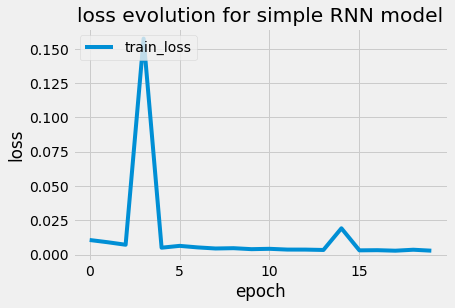

In [39]:
plot_loss(history_simple_rnn,'loss evolution for simple RNN model')

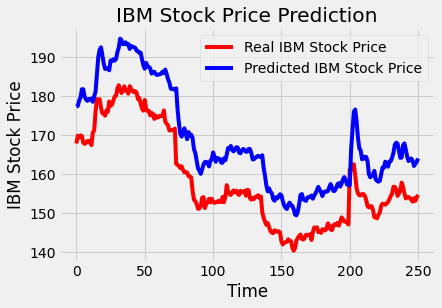

In [20]:
preds_simple_rnn = Simple_rnn.predict(X_test)
preds_simple_rnn = sc.inverse_transform(preds_simple_rnn)

plot_predictions(test_set,preds_simple_rnn)

In [21]:
print(return_rmse(test_set,preds_simple_rnn))

The root mean squared error is 10.564350351866963.
None


####GRU

In [22]:
gru_model = Sequential()

# GRU layer with 128 hidden units
gru_model.add(GRU(128,return_sequences=True, input_shape=(60,1),activation='tanh'))

# Add dropout 
gru_model.add(Dropout(0.25))

# 2nd GRU layer with 128 hidden units
gru_model.add(GRU(128,return_sequences=True,activation='tanh'))

# Add dropout 
gru_model.add(Dropout(0.25))

# 3rd gru layer with 128 hiden units
gru_model.add(GRU(128,activation='tanh'))

# Add dropout 
gru_model.add(Dropout(0.25))

# Dense layer 
gru_model.add(Dense(1))

gru_model.compile(optimizer='rmsprop',loss='mse')

gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 60, 128)           50304     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 60, 128)           99072     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [40]:
history_gru = gru_model.fit(X_train,y_train,
              epochs=20,
              verbose="auto",
              callbacks=None,
              shuffle=True,
              use_multiprocessing=False)



Epoch 1/20
85/85 [==============================] - 19s 180ms/step - loss: 0.0034
Epoch 2/20
85/85 [==============================] - 15s 180ms/step - loss: 0.0033
Epoch 3/20
85/85 [==============================] - 15s 180ms/step - loss: 0.0030
Epoch 4/20
85/85 [==============================] - 15s 180ms/step - loss: 0.0031
Epoch 5/20
85/85 [==============================] - 15s 180ms/step - loss: 0.0029
Epoch 6/20
85/85 [==============================] - 15s 179ms/step - loss: 0.0030
Epoch 7/20
85/85 [==============================] - 15s 179ms/step - loss: 0.0026
Epoch 8/20
85/85 [==============================] - 15s 179ms/step - loss: 0.0028
Epoch 9/20
85/85 [==============================] - 15s 180ms/step - loss: 0.0028
Epoch 10/20
85/85 [==============================] - 15s 179ms/step - loss: 0.0026
Epoch 11/20
85/85 [==============================] - 15s 180ms/step - loss: 0.0026
Epoch 12/20
85/85 [==============================] - 15s 180ms/step - loss: 0.0025
Epoch 13/20
8

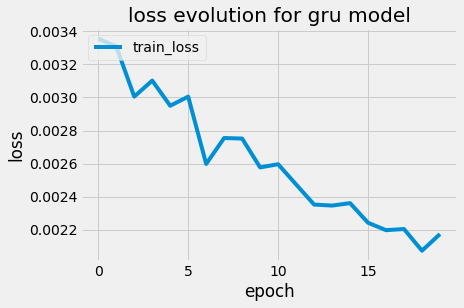

In [41]:

plot_loss(history_gru,'loss evolution for gru model')

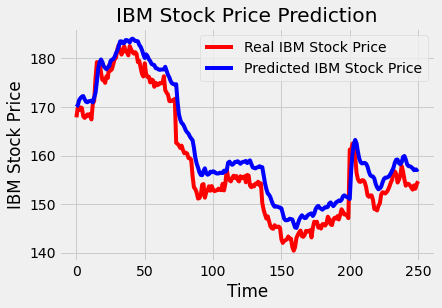

In [25]:

preds_gru = gru_model.predict(X_test)
preds_gru = sc.inverse_transform(preds_gru)

plot_predictions(test_set,preds_gru)


In [26]:
print(return_rmse(test_set,preds_gru))

The root mean squared error is 3.9223605790059146.
None


## LSTM

In [31]:
lstm_model = Sequential()

# 1st lstm layer with 128 hiden units
lstm_model.add(LSTM(128,return_sequences=True, input_shape=(60,1)))

# Add dropout 
lstm_model.add(Dropout(0.25))

# 2nd lstm layer with 128 hiden units
lstm_model.add(LSTM(128,return_sequences=True))

# Add dropout 
lstm_model.add(Dropout(0.25))

# 1st lstm layer with 128 hiden units
lstm_model.add(LSTM(128))

# Add dropout 
lstm_model.add(Dropout(0.25))

# Dense layer
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='rmsprop',loss='mse')
lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 60, 128)           66560     
_________________________________________________________________
dropout_15 (Dropout)         (None, 60, 128)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 60, 128)           131584    
_________________________________________________________________
dropout_16 (Dropout)         (None, 60, 128)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [32]:
history_lstm = lstm_model.fit(X_train,y_train,
              epochs=,
              verbose="auto",
              callbacks=None,
              shuffle=True,
              use_multiprocessing=False)



Epoch 1/20
85/85 [==============================] - 24s 215ms/step - loss: 0.0524
Epoch 2/20
85/85 [==============================] - 18s 215ms/step - loss: 0.0136
Epoch 3/20
85/85 [==============================] - 18s 215ms/step - loss: 0.0083
Epoch 4/20
85/85 [==============================] - 18s 216ms/step - loss: 0.0068
Epoch 5/20
85/85 [==============================] - 18s 214ms/step - loss: 0.0056
Epoch 6/20
85/85 [==============================] - 18s 217ms/step - loss: 0.0047
Epoch 7/20
85/85 [==============================] - 18s 216ms/step - loss: 0.0045
Epoch 8/20
85/85 [==============================] - 18s 214ms/step - loss: 0.0042
Epoch 9/20
85/85 [==============================] - 18s 215ms/step - loss: 0.0035
Epoch 10/20
85/85 [==============================] - 18s 213ms/step - loss: 0.0033
Epoch 11/20
85/85 [==============================] - 18s 217ms/step - loss: 0.0030
Epoch 12/20
85/85 [==============================] - 18s 215ms/step - loss: 0.0030
Epoch 13/20
8

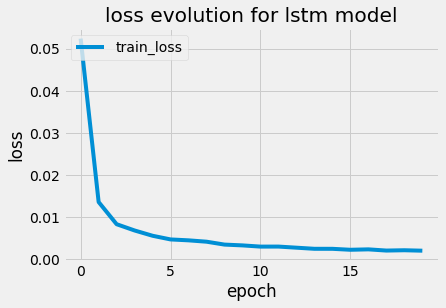

In [33]:

plot_loss(history_lstm,'loss evolution for lstm model')


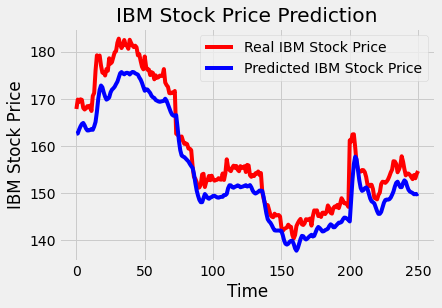

In [37]:

preds_lstm = lstm_model.predict(X_test)
preds_lstm = sc.inverse_transform(preds_lstm)

plot_predictions(test_set,preds_lstm)


In [48]:
print(return_rmse(test_set,preds_lstm))

The root mean squared error is 4.594721977325165.
None


## Review of models / Comparison :


<table>

  <thead>
    <th></th><th>RMSE</th><th>No of parameters</th><th>log(RMSE/No of parameters)</th>
  </thead>
  <tbody>
    <tr><th>Simple RNN</th><td>10.56</td><td>82,561</td><td>3.89</td></tr>
    <tr><th>LSTM</th><td>4.59</td><td>329,857</td><td>4.85</td></tr>
    <tr><th>GRU</th><td>3.92</td><td>249 351</td><td>4.80</td></tr>

    
  </tbody>
</table>

De point de vue budgétaire, **lstm** reste le plus couteux en termes de nombres de paramètres à entrainer, le **GRU** vient en deuxième position, **Simple_RNN** se positionne comme le moins couteux de ces types de réseaux cités au dessus.

De point de vue erreur, le **Simple_RNN** commet le **plus** d'erreur quadratique, le **LSTM** en deuxième position. Le **GRU** commet le minimum d'erreur entre les 3 modèles.

Pour trouver un compromis la formule de performance qu'on a calculé permet de conclure que le **GRU** est le meilleur compromis (budget/risque minime)

## Long term prediction

J'utilise dans cette partie le réseau LSTM déjà détaillé au début.



In [49]:
X_train = []
y_train = []
#### Préparer les labels pour tâche d'apprentissage de 7 jours dans le futur (les labels de chaque échantillon doit avoir 7 composantes )
for i in range(60,2762):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i:i+7,0]) # 7 days ahead 
X_train, y_train = np.array(X_train), np.array(y_train)

In [50]:
X_train = np.expand_dims(X_train, axis=2)

In [51]:
print(X_train.shape)
print(y_train.shape)

(2702, 60, 1)
(2702, 7)


In [52]:
##LSTM MODEL 

lstm_model = Sequential()

# 1st lstm layer with 128 hiden units
lstm_model.add(LSTM(128,return_sequences=True, input_shape=(60,1)))

# Add dropout 
lstm_model.add(Dropout(0.25))

# 2nd lstm layer with 128 hiden units
lstm_model.add(LSTM(128,return_sequences=True))

# Add dropout 
lstm_model.add(Dropout(0.25))

# 1st lstm layer with 128 hiden units
lstm_model.add(LSTM(128))

# Add dropout 
lstm_model.add(Dropout(0.25))

# Dense layer
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='rmsprop',loss='mse')
lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 60, 128)           66560     
_________________________________________________________________
dropout_18 (Dropout)         (None, 60, 128)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 60, 128)           131584    
_________________________________________________________________
dropout_19 (Dropout)         (None, 60, 128)           0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [53]:
history_lstm = lstm_model.fit(X_train,y_train,
              epochs=20,
              verbose="auto",
              callbacks=None,
              shuffle=True,
              use_multiprocessing=False)




Epoch 1/20
85/85 [==============================] - 23s 213ms/step - loss: 0.0268
Epoch 2/20
85/85 [==============================] - 18s 213ms/step - loss: 0.0107
Epoch 3/20
85/85 [==============================] - 18s 212ms/step - loss: 0.0084
Epoch 4/20
85/85 [==============================] - 18s 213ms/step - loss: 0.0067
Epoch 5/20
85/85 [==============================] - 18s 211ms/step - loss: 0.0055
Epoch 6/20
85/85 [==============================] - 18s 210ms/step - loss: 0.0046
Epoch 7/20
85/85 [==============================] - 18s 211ms/step - loss: 0.0043
Epoch 8/20
85/85 [==============================] - 18s 213ms/step - loss: 0.0041
Epoch 9/20
85/85 [==============================] - 18s 212ms/step - loss: 0.0038
Epoch 10/20
85/85 [==============================] - 18s 211ms/step - loss: 0.0035
Epoch 11/20
85/85 [==============================] - 18s 210ms/step - loss: 0.0033
Epoch 12/20
85/85 [==============================] - 18s 211ms/step - loss: 0.0032
Epoch 13/20
8

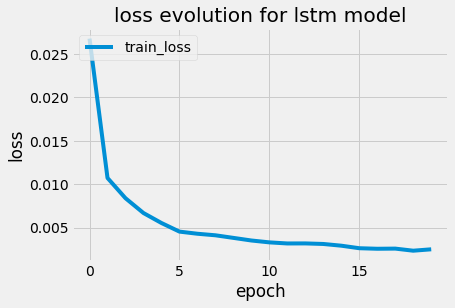

In [54]:
plot_loss(history_lstm,'loss evolution for lstm model')



In [59]:
preds_lstm = lstm_model.predict(X_test)
preds_lstm = sc.inverse_transform(preds_lstm)


(251, 1)

In [60]:


def rmse(test_set,preds,days):
  return math.sqrt(mean_squared_error(test_set, preds))


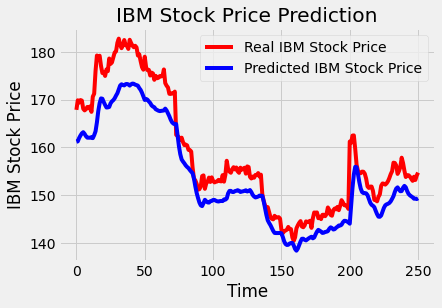

In [61]:
#plot prediction 7 days ahead

plot_predictions(test_set,preds_lstm)


In [63]:
rmse_7days = rmse(test_set,preds_lstm,7)
print("for predictions 1 week a head, RMSE : ", rmse_7days)

for predictions 1 week a head, RMSE :  5.512310147510773
